In [10]:
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

torch.manual_seed(1)
torch.cuda.set_device(1)

### Energy Estimation for various choices of w

In [11]:
class SmallMLP(nn.Module):
    def __init__(self, n_dims, n_hid=8, layer=nn.Linear):
        super(SmallMLP, self).__init__()

        self.net = nn.Sequential(
            layer(n_dims, n_hid),
            nn.SiLU(),
            layer(n_hid, n_hid),
            nn.SiLU(),
            layer(n_hid, 1)
        )

    def forward(self, u):
        out = self.net(u)
        return out
    
def energy_discrepancy(energy_net, samples, m_particles=4, t_noise=1.0, w_stable=1.0):
    device = samples.device

    browniani = torch.randn_like(samples).to(device) * np.sqrt(t_noise)
    brownianij = torch.randn(samples.size(0), m_particles, *samples.shape[1:]).to(device) * np.sqrt(t_noise)

    pert_data = samples.unsqueeze(1) + browniani.unsqueeze(1) + brownianij

    pos_energy = energy_net(samples)
    neg_energy = energy_net(pert_data.view(-1, *samples.shape[1:])).view(samples.size(0), -1)
    val = pos_energy - neg_energy
    if w_stable != 0:
        val = torch.cat([val, np.log(w_stable) * torch.ones_like(val[:, :1])], dim=-1)

    loss = val.logsumexp(dim=-1).mean()
    if t_noise < 1.:
        loss = loss / t_noise
    return loss

def train(model, data, w=1., n_epochs=50, batch_size=64):    
        
    opt = torch.optim.Adam(model.parameters(), lr=0.01)
    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                          shuffle=True)
    
    for _ in tqdm(range(n_epochs)):
        
        for _ in dataloader:
            opt.zero_grad()
            loss_val = energy_discrepancy(energy_net=model, samples=data, w_stable=w)
            loss_val.backward()
            opt.step()
            
    return model

100%|██████████| 50/50 [00:13<00:00,  3.74it/s]


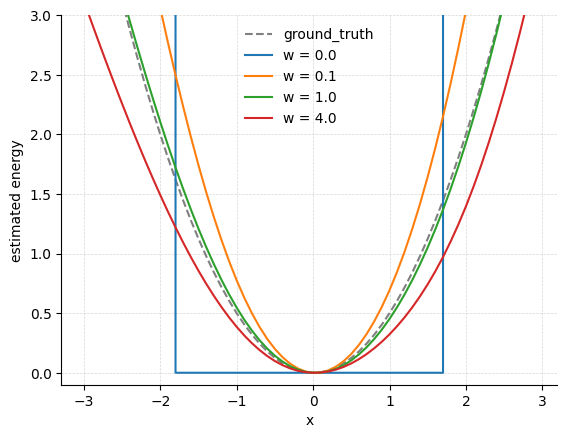

In [12]:
n = 4096
ws = [0., 0.1, 1., 4.]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = torch.randn(n, 1).to(device)
x = torch.arange(-3, 3, 0.1)
y_true = x**2 / 2

fig, ax = plt.subplots()
plt.plot(x, y_true, '--', label = f'ground_truth', color = 'grey')

for w in ws:
    model = SmallMLP(n_dims = 1, n_hid = 2).to(device)
    model = train(model, data, w=w)
    y = model(x.unsqueeze(1).to(device)).cpu().detach().numpy()
    y = y - y.min()
    plt.plot(x, y, label = f'w = {w}')
    
plt.grid(True)
plt.xlabel("x")
plt.ylim(-0.1, 3.)
plt.legend(frameon = False)
plt.ylabel("estimated energy")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.savefig('Tuningwform=4.png', dpi=300)